# Multiple Linear Regression

## Predicting Insurance Cost

Notebook by Anthony Rodriguez

In [1]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils_common import *

# Introduction

This notebook displays exploratory data analysis (EDA) and multiple linear regression on a [kaggle dataset for predicting medical/insurance cost with multiple linear regression](https://www.kaggle.com/datasets/mirichoi0218/insurance). This data set is just going to be used to practice using basic EDA, simple data-cleaning, and linear regression with multiple variables.

# Exploratory Data Analysis (EDA)

In [2]:
filename = "insurance.csv"

In [3]:
data_file = fetch_file(filename)
data_file

WindowsPath('data/insurance.csv')

Let's look at the size of the file.

In [4]:
print(f'training_set_file is {os.path.getsize(data_file) / 1e6} MB')

training_set_file is 0.055628 MB


Let's look at the number of lines in the data.

In [5]:
num_lines = num_lines_in_file(data_file)
print(f'The training set file has {num_lines} lines of data.')

The training set file has 1339 lines of data.


Let's check the contents of the file to make sure it is a csv file.

In [6]:
print_file_contents(data_file)

data\insurance.csv ===========================
0	'age,sex,bmi,children,smoker,region,charges\n'
1	'19,female,27.9,0,yes,southwest,16884.924\n'
2	'18,male,33.77,1,no,southeast,1725.5523\n'
3	'28,male,33,3,no,southeast,4449.462\n'
4	'33,male,22.705,0,no,northwest,21984.47061\n'
5	'32,male,28.88,0,no,northwest,3866.8552\n'
6	'31,female,25.74,0,no,southeast,3756.6216\n'
7	'46,female,33.44,1,no,southeast,8240.5896\n'
8	'37,female,27.74,3,no,northwest,7281.5056\n'
9	'37,male,29.83,2,no,northeast,6406.4107\n'
10	'60,female,25.84,0,no,northwest,28923.13692\n'
11	'25,male,26.22,0,no,northeast,2721.3208\n'
12	'62,female,26.29,0,yes,southeast,27808.7251\n'
13	'23,male,34.4,0,no,southwest,1826.843\n'
14	'56,female,39.82,0,no,southeast,11090.7178\n'
15	'27,male,42.13,0,yes,southeast,39611.7577\n'
16	'19,male,24.6,1,no,southwest,1837.237\n'
17	'52,female,30.78,1,no,northeast,10797.3362\n'
18	'23,male,23.845,0,no,northeast,2395.17155\n'
19	'56,male,40.3,0,no,southwest,10602.385\n'


File looks like a standard csv file with multiple columns consisting of real numbers and strings.

Let's create a data frame.

In [7]:
df = pd.read_csv(data_file)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Let's be sure of the types within the data frame.

In [8]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Let's see unique values of the categorical data.

In [9]:
df['sex'].unique()

array(['female', 'male'], dtype=object)

In [10]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [11]:
df['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [12]:
print('Any null values in numerical features?')
df[['age', 'bmi', 'children']].isnull().any()

Any null values in numerical features?


age         False
bmi         False
children    False
dtype: bool

Let's see the ranges of the numerical data.

In [13]:
print(f"Minimums:\n\n{df[['age', 'bmi', 'children']].min()}\n\n")
print(f"Maximums:\n\n{df[['age', 'bmi', 'children']].max()}\n\n")
print(f"Peak to Peak values: {np.ptp(df[['age', 'bmi', 'children']].to_numpy(), axis=0)}")

Minimums:

age         18.00
bmi         15.96
children     0.00
dtype: float64


Maximums:

age         64.00
bmi         53.13
children     5.00
dtype: float64


Peak to Peak values: [46.   37.17  5.  ]


Let's see how the numerical data compares to the charge of insurance of cost.

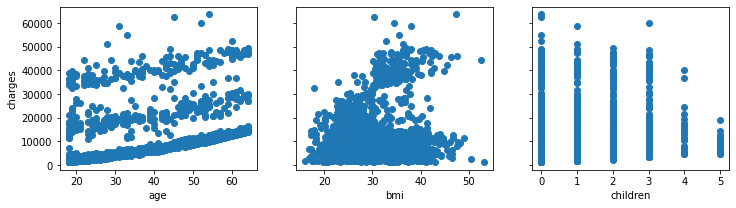

In [14]:
X_train = df[['age', 'bmi', 'children']].to_numpy()
X_features = ['age', 'bmi', 'children']
y_train = df[['charges']].to_numpy()

fig,ax=plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("charges")
plt.show()

As age gets higher, charges get highter. Likewise it seems bmi does trend upward with age, although not as much as age trends upward. Children is kind of hard to figure out. From 0-3 children, there does not seem to be a difference, making you believe that the number of children do not matter in insurance cost. But 4 and 5 children have a dramatic drop in insurance cost.

# Training a Multiple Linear Regression Model Using Numerical Data

For now, let's just train a model using numerical data. That is, the features of age, bmi, and children. Later, we will add categorical data for a better model.

In [30]:
X_train = df[['age', 'bmi', 'children']]
y_train = df[['charges']]
X_train.head()

,age,bmi,children
0,19,27.900,0
1,18,33.770,1
2,28,33.000,3
3,33,22.705,0
4,32,28.880,0


# Training a Univariate Linear Regression Model

#### This data will allow us to use a mulitple linear function $f$ of a vector $\mathbf{x}$, containing multiple variables. That is, $f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b$. 

$\mathbf{w}$, a vector, and $b$, a scalar, are parameters we must find.

#### We can do this by minimizing the cost $J(\mathbf{w},b) = \frac{1}{2m}\sum\limits^{m-1}_{i=0}(f_{w,b}(\mathbf{x}^{(i)}) - y^{(i)})^{2}$
#### where $f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b$ is the estimated cost of training example $\mathbf{x}^{(i)}$.

#### $y^{(i)}$ is the true cost of training example $\mathbf{x}^{(i)}$.

#### In order to find $\mathbf{w}$ and $b$ by minimizing the cost $J(\mathbf{w},b)$, we must use it's gradient

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial \mathbf{w}}  &= \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})\mathbf{x}^{(i)} \newline
  \frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})
\end{align}
$$

#### We then repeat until convergence

$$\begin{align*} \newline
\;  \mathbf{w} &= \mathbf{w} -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial \mathbf{w}} \newline 
 b &= b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline
\end{align*}$$

#### where, parameters $\mathbf{w}$, $b$ are updated simultaneously.

In [31]:
def compute_loss(x, y, w, b, i):
    """
    Creates a linear model using parameters w and b to
    compute a predicted value with the ith training example
    and then computes the loss of the predicted value.
    
    x: The training examples.
    y: The target/actual value.
    w: The weight of the feature/training example x.
    b: A model parameter.
    i: The index of the training example.
    
    returns: The loss/error of the model prediction of the ith training example.
    """
    f_xi = np.dot(w , x[i]) + b
    return f_xi - y[i]

In [32]:
def compute_mse(x, y, w, b):
    """
    Computes the mean-squared error of the model.
    
    x: The training examples.
    y: The target/actual value.
    w: The weight of the feature/training example x.
    b: A model parameter.
    
    returns: The mean-squared error.
    """
    m = x.shape[0]
    i = 0
    total_loss = 0
    
    while i < m:
        loss_i = compute_loss(x, y, w, b, i)
        total_loss = total_loss + (loss_i**2)
        i += 1
    
    return total_loss / m

In [33]:
def compute_cost(x, y, w, b):
    """
    The model cost.
    
    x: The training examples.
    y: The target values.
    w: The weight of the features/training examples x.
    b: A model parameter.
    
    returns: The cost of the model.
    """
    return compute_mse(x, y, w, b) / 2

In [34]:
def compute_gradient(x, y, w, b):
    """
    Computes the gradient for linear regression.
    
    x: The training examples.
    y: The target values.
    w: The weight of the features/training examples x.
    b: A model parameter.
    
    returns: The gradient w.r.t. w and the gradient w.r.t. b
    """
    m = x.shape[0]
    i = 0
    loss = 0
    dj_dw = 0
    dj_db = 0
    
    while i < m:
        loss = compute_loss(x, y, w, b, i)
        dj_dw_i = loss * x[i]
        dj_db_i = loss
        dj_dw += dj_dw_i
        dj_db += dj_db_i
        i += 1
        
    dj_dw, dj_db = dj_dw  / m, dj_db / m
    return dj_dw, dj_db

In [58]:
class Gradient_Descent:
    """
    A class for the gradient descent algorithm.
    """
    def __init__(self, cost_function, gradient_function, alpha, max_iters):
        """
        Creates an Gradient_Descent object.
        
        self: A Gradient_Descent object.
        cost_function: A function that computes the model cost.
        gradient_function: A function that computes the gradient.
        alpha (float): The learning rate.
        max_iters (int): The maximum number of iterations of the gradient descent algorithm.
        """
        self.cost_function = cost_function
        self.gradient_function = gradient_function
        self.alpha = alpha
        self.max_iters = max_iters
        
    def algorithm(self, X_train, y_train, w_in, b):
        '''
        Much of this gradient descent code is from Andrew Ng's Machine Learning course.
        
        The gradient descent algorithm.
        
        self: A Gradient_Descent object.
        X_train (ndarray (m,n)): The training examples.
        y_train (ndarray (m,)) : The targets.
        w_in ndarray (n,)): The parameter/weight of the training examples.
        b (scalar): A model parameter.
        '''
        
        w = np.copy(w_in)
        
        # An array to store cost J and w's at each iteration primarily for graphing later
        J_history = []
        p_history = []
        
        header = 'Iteration | Cost      '
        
        for i in range(w.shape[0]):
            header += f' | w_{i}   '
            
        header += '| b      '
            
        for i in range(w.shape[0]):
            header += f' | dj_dw_{i} '
            
        header += ' | dj_db  |'    
        print(header)

        for i in range(self.max_iters):
            # Calculate the gradient and update the parameters using gradient_function
            dj_dw, dj_db = self.gradient_function(X_train, y_train, w , b)
            
            # Record old parameters
            last_b, last_w = b, w

            # Update Parameters
            b = b - alpha * dj_db                            
            w = w - alpha * dj_dw
            
            # Check if new parameters are equal to the last iterations parameters
            if self.are_equal(b, last_b) and self.arrays_are_equal(w, last_w):
                print('Convergence')
                info = f'{i}\t    {J_history[-1][0]:.2}\t'
                
                for w_i in w:
                    info += f'{w_i:.1e}  '
                    
                info += f'{b[0]:.1e}  '
                    
                for dj_dw_i in dj_dw:
                    info += f' {dj_dw_i:.1e}  '
                
                info += f'{dj_db[0]:.1e}'
                print(info)
                
                break
                
            # Save cost J at each iteration
            if i<100000:      # prevent resource exhaustion 
                J_history.append(self.cost_function(X_train, y_train, w , b))
                p_history.append([w,b])
            # Print cost every at intervals 10 times or as many iterations if max iters < 10
            if i% math.ceil(self.max_iters/10) == 0:
                info = f'{i}\t    {J_history[-1][0]:.2}\t'
                
                for w_i in w:
                    info += f'{w_i:.1e}  '
                    
                info += f'{b[0]:.1e}  '
                    
                for dj_dw_i in dj_dw:
                    info += f' {dj_dw_i:.1e}  '
                
                info += f'{dj_db[0]:.1e}'
                print(info)
                #print(f'Iteration {i:4}: Cost {J_history[-1]}',
                #     f'dj_dw: {dj_dw}, dj_db: {dj_db}')
                #print(f"w: {w}, b:{b}")

        return w, b, J_history, p_history #return w and J,w history for graphing
    
    def are_equal(self, old_val, new_val, epsilon = 1.0e-6):
        return abs(old_val - new_val) < epsilon
    
    def arrays_are_equal(self, old_arr, new_arr):
        epsilon = 1.0e-6
        are_equal = abs(old_arr - new_arr) < epsilon
        return are_equal.all()
        

In [59]:
%%time
# Gradient descent settings
w_init = np.zeros_like(X_train.to_numpy()[0])
iterations = 10000
alpha = 1.0e-4
gradient_descent = Gradient_Descent(compute_cost, compute_gradient, alpha, iterations)
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent.algorithm(X_train.to_numpy(), y_train.to_numpy(), w_init, 0)
print(f"(w,b) found by gradient descent: ({w_final},{b_final})\n")

Iteration | Cost       | w_0    | w_1    | w_2   | b       | dj_dw_0  | dj_dw_1  | dj_dw_2  | dj_db  |
0	    1.2e+08	5.7e+01  4.2e+01  1.6e+00  1.3e+00   -5.7e+05   -4.2e+05   -1.6e+04  -1.3e+04
1000	    6.5e+07	2.1e+02  1.7e+02  6.1e+01  -1.5e+01   3.2e+00   7.2e+00   -5.1e+02  2.1e+02
2000	    6.5e+07	2.1e+02  1.7e+02  1.1e+02  -3.6e+01   2.5e+00   5.6e+00   -4.4e+02  2.1e+02
3000	    6.5e+07	2.1e+02  1.7e+02  1.5e+02  -5.7e+01   2.0e+00   4.2e+00   -3.8e+02  2.1e+02
4000	    6.5e+07	2.1e+02  1.7e+02  1.9e+02  -7.7e+01   1.6e+00   2.9e+00   -3.3e+02  2.1e+02
5000	    6.5e+07	2.1e+02  1.7e+02  2.2e+02  -9.8e+01   1.2e+00   1.8e+00   -2.9e+02  2.1e+02
6000	    6.5e+07	2.1e+02  1.7e+02  2.4e+02  -1.2e+02   9.3e-01   8.4e-01   -2.5e+02  2.1e+02
7000	    6.5e+07	2.1e+02  1.7e+02  2.7e+02  -1.4e+02   6.6e-01   2.9e-02   -2.1e+02  2.1e+02
8000	    6.5e+07	2.1e+02  1.7e+02  2.9e+02  -1.6e+02   4.3e-01   -6.7e-01   -1.8e+02  2.1e+02
9000	    6.5e+07	2.1e+02  1.7e+02  3.0e+02  -1.8e+02   2.3e-

#### That took a long time and with results that are not that great. Let's try to normalize the training data with Z-Score normalization.

In [60]:
X_train_np = X_train.to_numpy()
X_train_norm = (X_train_np - np.mean(X_train_np, axis=0)) / np.std(X_train_np, axis=0)
X_train_norm

array([[-1.43876426, -0.45332   , -0.90861367],
       [-1.50996545,  0.5096211 , -0.07876719],
       [-0.79795355,  0.38330685,  1.58092576],
       ...,
       [-1.50996545,  1.0148781 , -0.90861367],
       [-1.29636188, -0.79781341, -0.90861367],
       [ 1.55168573, -0.26138796, -0.90861367]])

In [61]:
np.ptp(X_train_norm, axis=0)

array([3.27525475, 6.09753333, 4.14923238])

In [62]:
%%time
alpha = 1.0e-2
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent.algorithm(X_train_norm, y_train.to_numpy(), w_init, 0)
print(f"(w,b) found by gradient descent: ({w_final},{b_final})\n")

Iteration | Cost       | w_0    | w_1    | w_2   | b       | dj_dw_0  | dj_dw_1  | dj_dw_2  | dj_db  |
0	    1.6e+08	3.6e+01  2.4e+01  8.2e+00  1.3e+02   -3.6e+03   -2.4e+03   -8.2e+02  -1.3e+04
1000	    6.4e+07	3.4e+03  2.0e+03  6.5e+02  1.3e+04   -1.2e-01   3.4e-02   2.2e-02  -5.7e-01
Convergence
1861	    6.4e+07	3.4e+03  2.0e+03  6.5e+02  1.3e+04   -4.0e-05   3.2e-05   1.2e-05  -1.0e-04
(w,b) found by gradient descent: ([3370.65251789 2024.34955566  654.17481353],[13270.42216615])

CPU times: total: 29.2 s
Wall time: 29.5 s


That was fast! Let's see what parameters we get using Scikt-learn.

In [86]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [87]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train_np,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

Peak to Peak range by column in Raw        X:[46.   37.17  5.  ]
Peak to Peak range by column in Normalized X:[3.27525475 6.09753333 4.14923238]


In [88]:
sgdr = SGDRegressor(max_iter=10000)
sgdr.fit(X_norm, y_train.values.flatten())

SGDRegressor(max_iter=10000)

In [89]:
b_norm = sgdr.intercept_
w_norm = sgdr.coef_
print(f"(w,b) found by Scikit-learn's SGDRegressor w: {w_norm}, b: {b_norm}")

(w,b) found by Scikit-learn's SGDRegressor w: [3354.59260186 2098.66181623  675.49957232], b: [13279.13361261]


The parameters are pretty close to the Python model.

# Data Processing

## Categorical Encoding

Since we know that **sex**, **smoker**, and **region** are categorical features, we must use categorical encoding to use features that are real numbers. Let's use **one-hot encoding**.

### One-Hot Encoding

In [26]:
unique_vals = df['sex'].unique()
males = np.zeros(unique_vals.size)
males

array([0., 0.])

# Training a Multiple Linear Regression Model